In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import sys
scripts_path = os.path.abspath('../scripts')
if not scripts_path in sys.path:
    sys.path.insert(1, scripts_path)
    
from transformation import detect_markers_and_compute
from text_detection import detect_boxes, get_text_boxes_from_data
from run_detection_pipeline import cut_edges

import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
from pytesseract import Output

In [2]:
W_WORLD, H_WORLD = 420, 297  # size of area marked by inner points of aruco markers in mm
WORLD2IMG_SCALE = 7.5  # scale factor for transforming cm to pixels in the birds eye image
H_IMG, W_IMG = int(H_WORLD * WORLD2IMG_SCALE), int(W_WORLD * WORLD2IMG_SCALE)
BORDER_FRACTION_TO_CUT = 0.01
H_OFFSET = int(H_IMG * BORDER_FRACTION_TO_CUT)
W_OFFSET = int(W_IMG * BORDER_FRACTION_TO_CUT)

In [3]:
def prep(img_path):
    img = cv2.imread(img_path)
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    m, debug_img_marker = detect_markers_and_compute(img_gs, (H_IMG, W_IMG), debug_image=True)

    # transform the image into a top down perspective
    img_warped = cv2.warpPerspective(img, m, (W_IMG, H_IMG))
    img_warped_gs = cv2.warpPerspective(img_gs, m, (W_IMG, H_IMG))

    # cut edges
    img_cutted, img_cutted_gs = list(cut_edges([img_warped, img_warped_gs]))
    
    # detect circles and text
    return cv2.adaptiveThreshold(img_cutted_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 30)

In [4]:
def detect_text(img_path, config_leg, config_lstm):
    thres = prep(img_path)
    dtct_dict_legacy = pytesseract.image_to_data(thres, config=config_leg,
                                                 output_type=Output.DICT)
    dtct_dict_lstm = pytesseract.image_to_data(thres, config=config_lstm,
                                               output_type=Output.DICT)
    return get_text_boxes_from_data(dtct_dict_legacy), get_text_boxes_from_data(dtct_dict_lstm), thres

In [5]:
def detect_boxes(img, config):
    d = pytesseract.image_to_data(img, config=config, output_type=Output.DICT)
    return get_text_boxes_from_data(d)

def choose_box(boxes):
    """ Choose a box out of multiple detections for the same number. """
    if len(boxes) <= 1:
        return boxes
    
    # expected width and height of the box in pixels
    w_exp = len(boxes[0].text)*25 
    h_exp = 30
    
    # filter boxes that are definitley to small
    accepted = []
    for box in boxes:
        if abs(box.h-h_exp) < 5:
            accepted.append(box)
    if len(accepted) == 0:
        return accepted
    
    widths = np.abs(np.asarray([b.w for b in accepted]) - w_exp)
    if boxes[0].text == '5':
        print([(b.x, b.y) for b in accepted])
        
    return [accepted[np.argmin(widths)]]
    
def detect_multiple_runs(img_path, configs):
    thres = prep(img_path)
    
    # run detection for all configurations
    detections = [detect_boxes(thres, c) for c in configs]
    detections = [b for sublist in detections for b in sublist]
    
    nums = {}
    for box in detections:
        if int(box.text) > 50:
            continue
        elif box.text in nums.keys():
            nums[box.text].append(box)
        else:
            nums[box.text] = [box]
    
    accepted_detections = []
    for text, boxes in nums.items():
        accepted_detections += choose_box(boxes)
            
    return accepted_detections, thres

In [6]:
image_path_tmpl = os.path.abspath('../data/test-images/test-font-size - {}.jpg')

In [7]:
def plot(path, clega, clstm):
    boxes_legacy, boxes_lstm, dimg_text = detect_text(path, clega, clstm)
    _, ax = plt.subplots(ncols=2, figsize=(20,20))

    res = cv2.cvtColor(dimg_text, cv2.COLOR_GRAY2BGR)
    for t in boxes_legacy:
        cv2.putText(res, t.text, (t.x + t.w, t.y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2, cv2.LINE_AA)
        cv2.rectangle(res, (t.x, t.y), (t.x + t.w, t.y + t.h), (255,0,0), 4)
    ax[0].imshow(res, cmap='gray')
    ax[0].set_title(clega)
    ax[0].axis('off')

    res = cv2.cvtColor(dimg_text, cv2.COLOR_GRAY2BGR)
    for t in boxes_lstm:
        cv2.putText(res, t.text, (t.x + t.w, t.y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2, cv2.LINE_AA)
        cv2.rectangle(res, (t.x, t.y), (t.x + t.w, t.y + t.h), (255,0,0), 4)
    ax[1].imshow(res, cmap='gray')
    ax[1].set_title(clstm)
    ax[1].axis('off')

    plt.tight_layout()

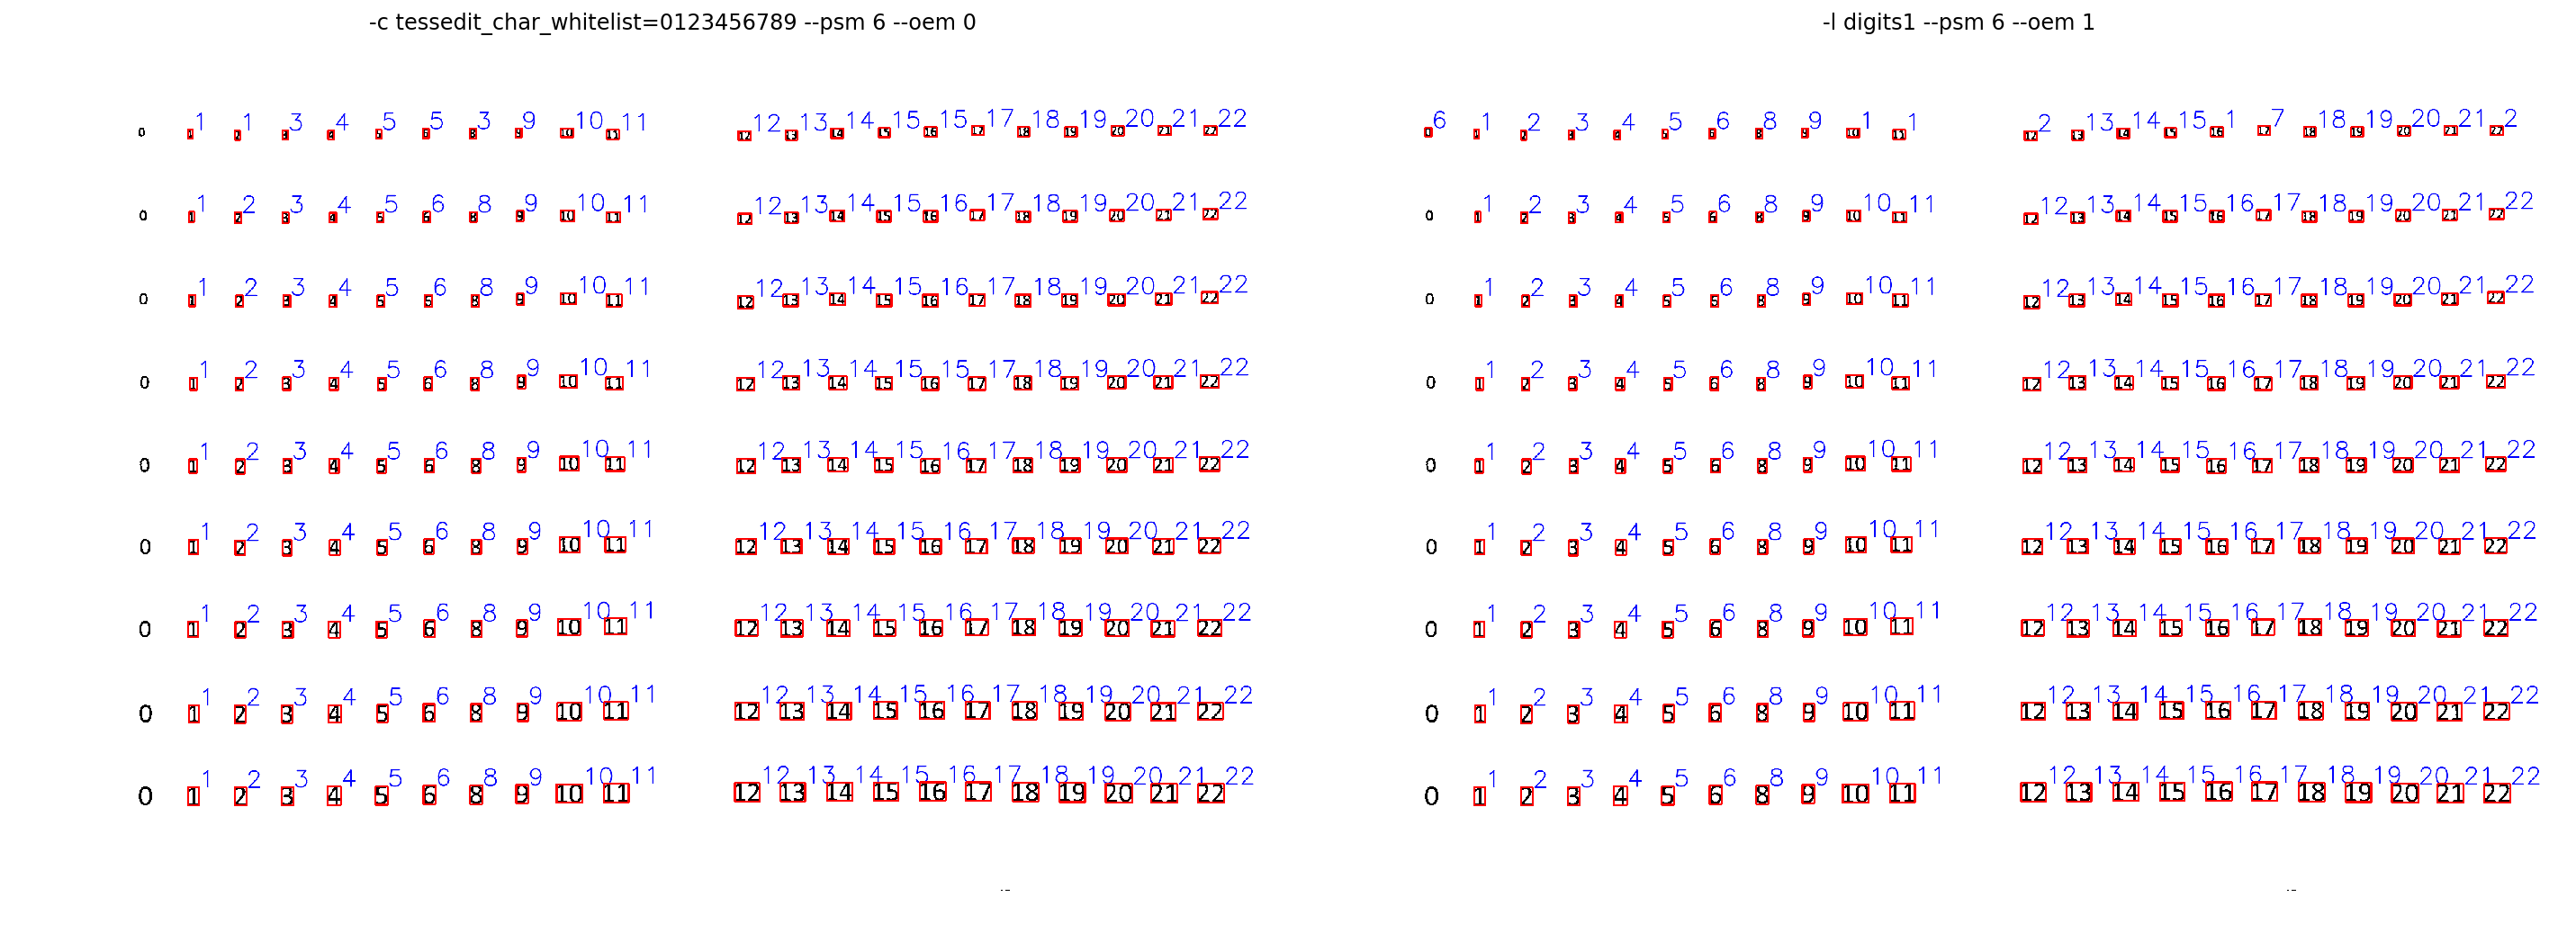

In [72]:
plot(image_path_tmpl.format(2), 
     '-c tessedit_char_whitelist=0123456789 --psm 6 --oem 0', 
     '-l digits1 --psm 6 --oem 1')
#plt.savefig('/Users/Johannes/Desktop/out.png', dpi=400)

In [8]:
iats = os.path.abspath('../data/test-images/test-iat - {}.jpg')

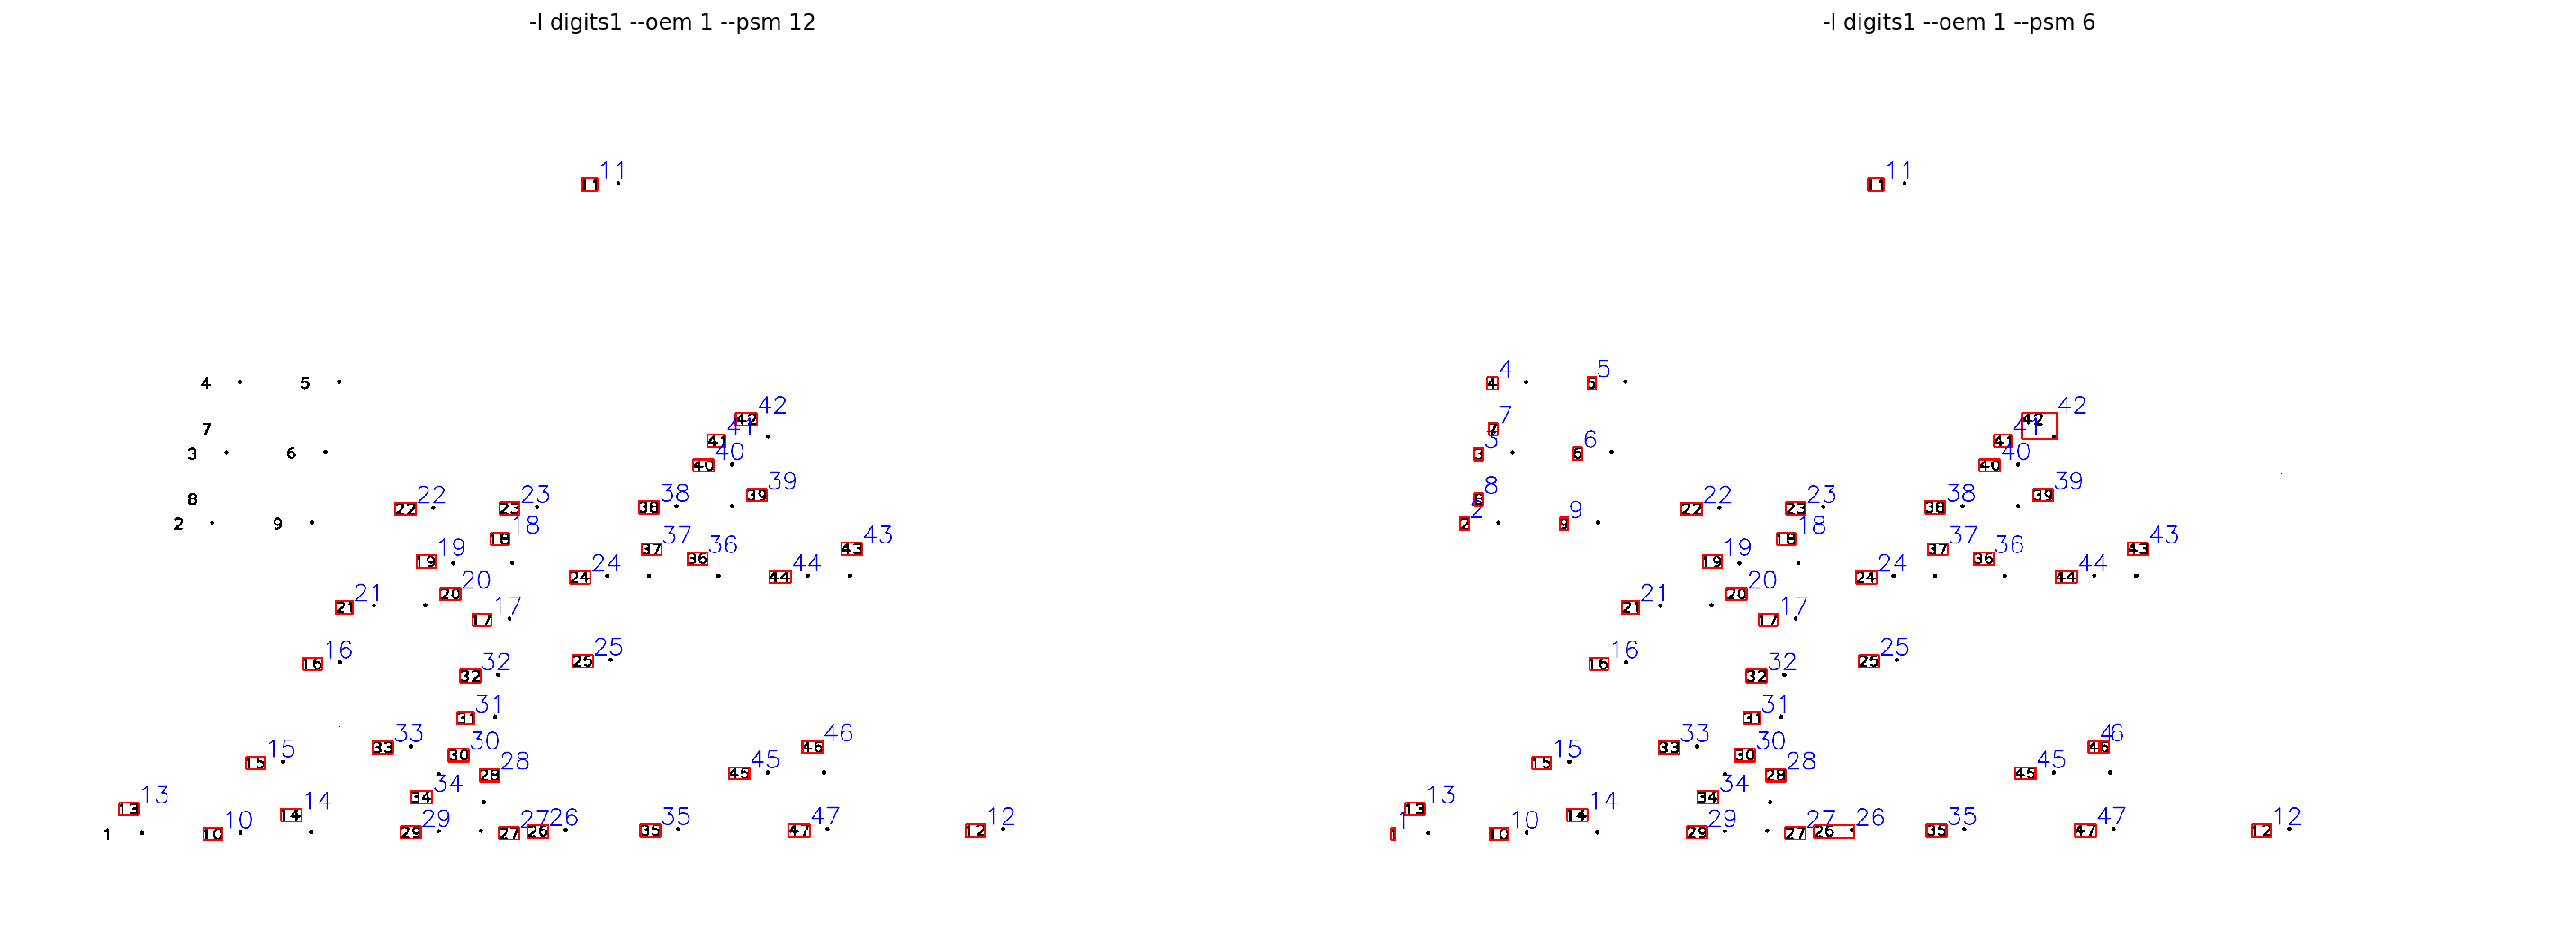

In [13]:
plot(iats.format(5), 
     '-l digits1 --oem 1 --psm 12', 
     '-l digits1 --oem 1 --psm 6')
#plt.savefig('/Users/Johannes/Desktop/a.png', dpi=400)

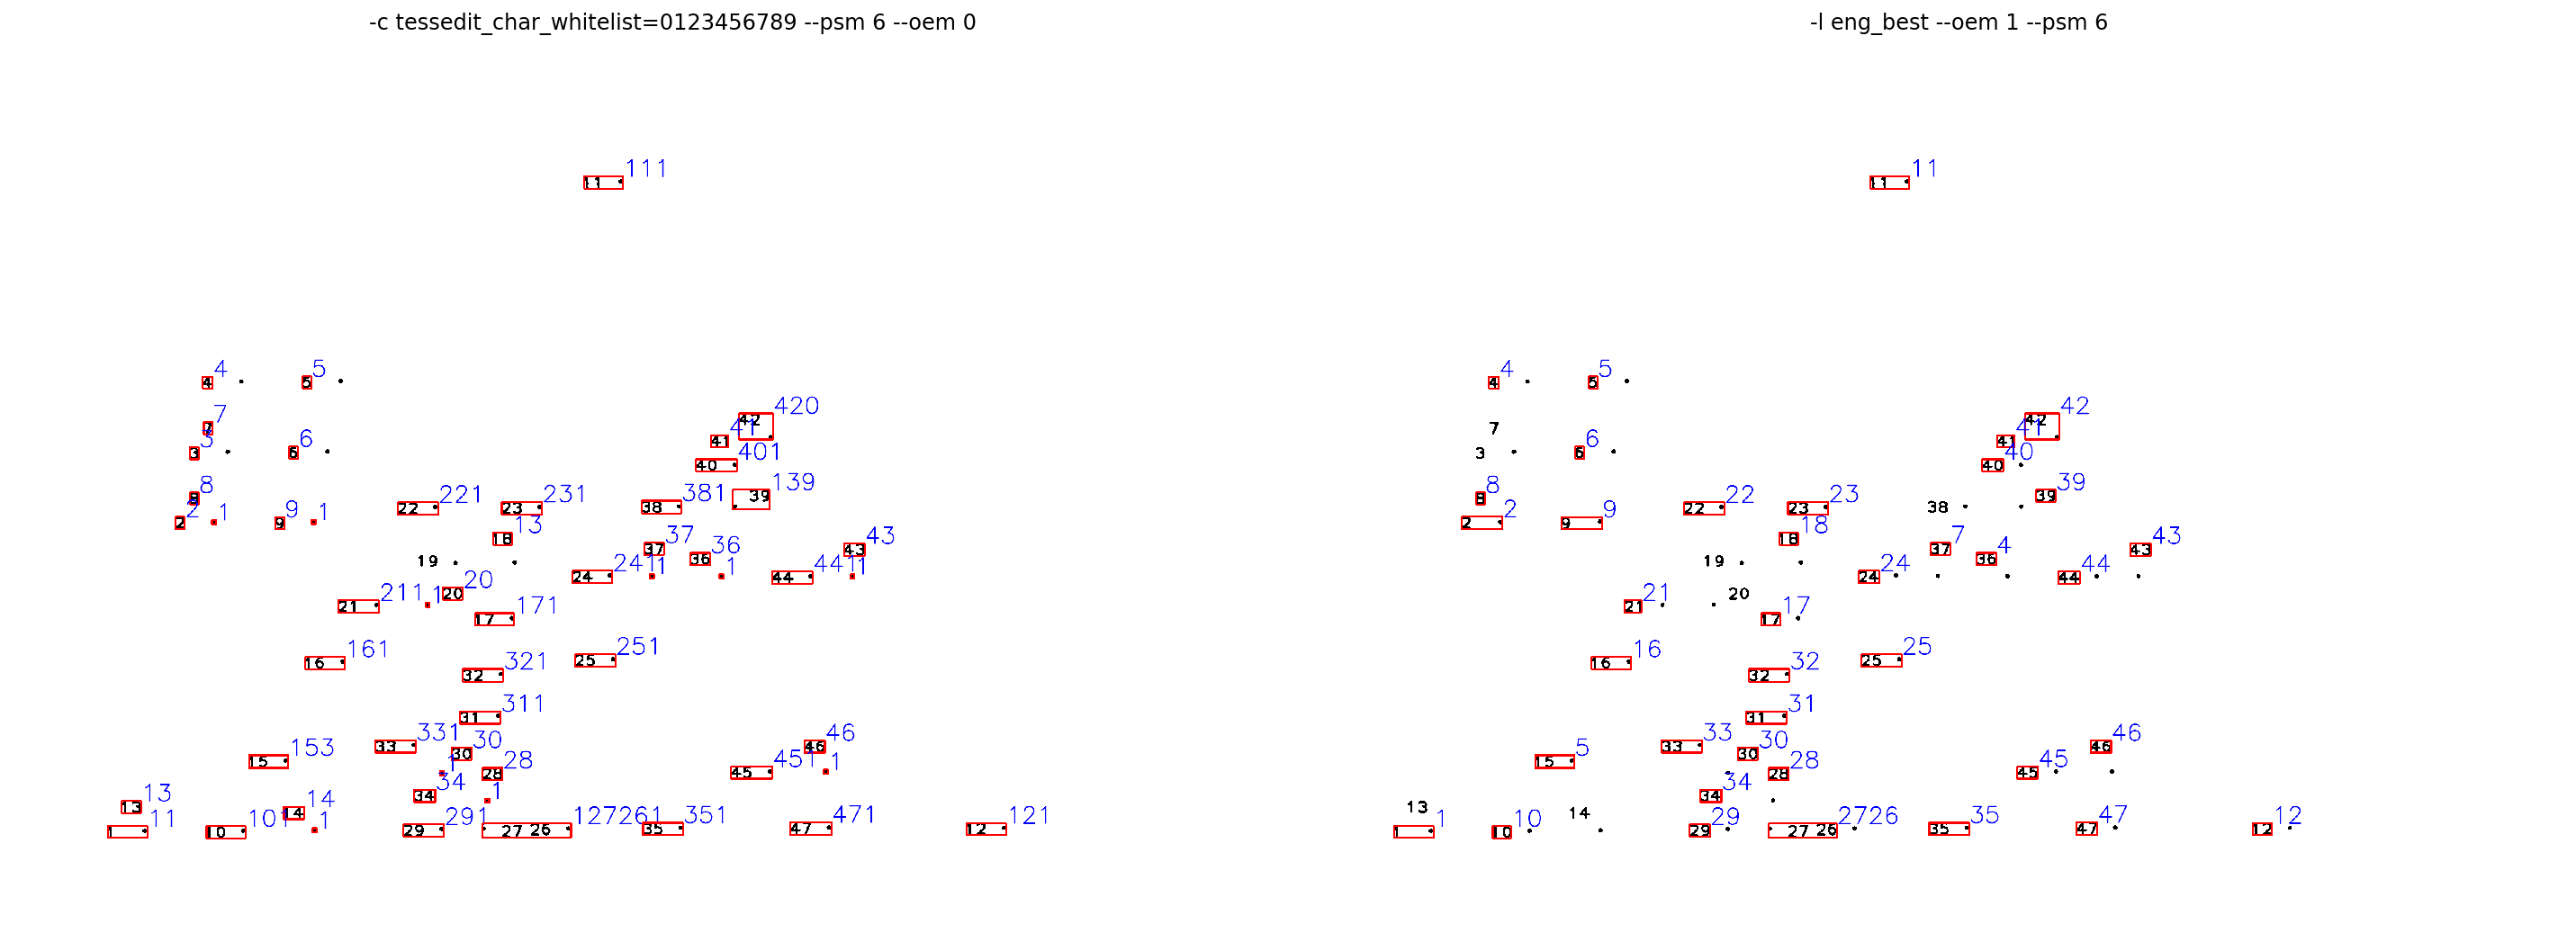

In [169]:
plot(iats.format(1), 
     '-c tessedit_char_whitelist=0123456789 --psm 6 --oem 0', 
     '-l eng_best --oem 1 --psm 6')

[(592, 862), (302, 1043), (592, 862)]


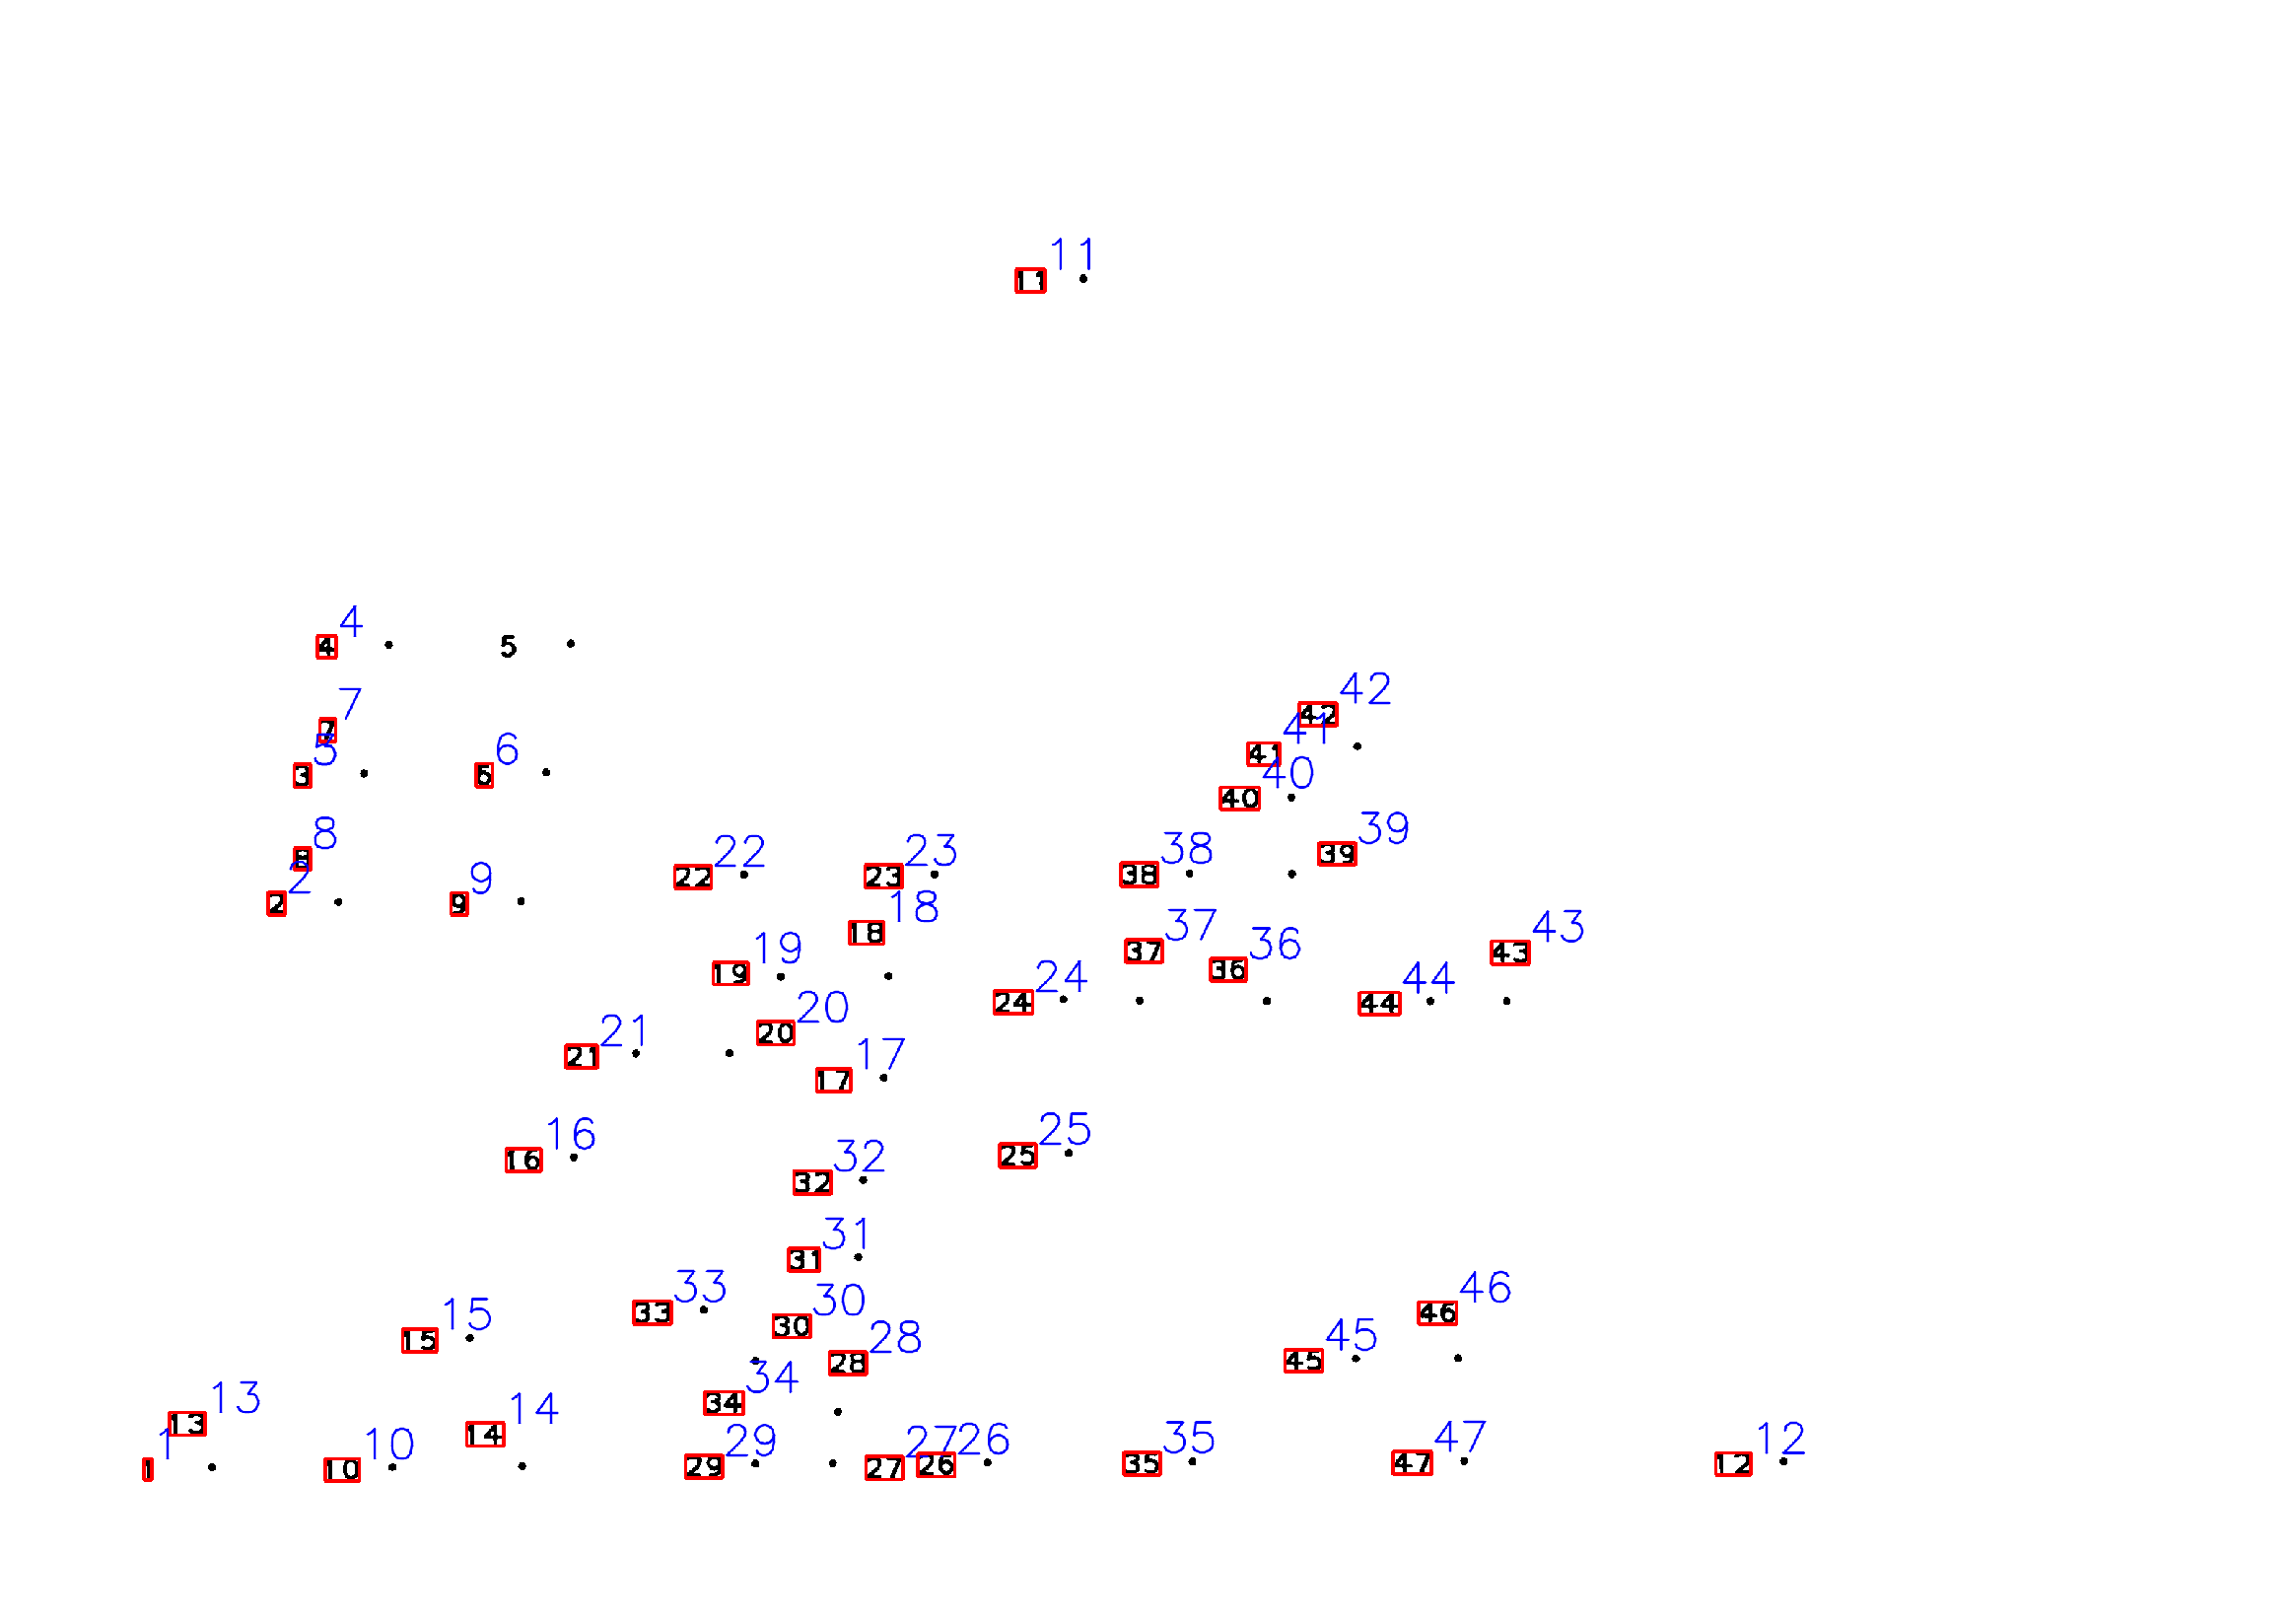

In [163]:
cfgs = ['-l digits1 --oem 1 --psm 12',
        '-l digits1 --oem 1 --psm 6', 
        '-c tessedit_char_whitelist=0123456789 --psm 6 --oem 0']
boxes, dimg_text = detect_multiple_runs(iats.format(1), cfgs)

fig, ax = plt.subplots(figsize=(20, 20))
res = cv2.cvtColor(dimg_text, cv2.COLOR_GRAY2BGR)
for t in boxes:
    cv2.putText(res, t.text, (t.x + t.w, t.y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2, cv2.LINE_AA)
    cv2.rectangle(res, (t.x, t.y), (t.x + t.w, t.y + t.h), (255,0,0), 4)
ax.imshow(res, cmap='gray')
ax.axis('off');
